# Predicting the Price of Dogecoin

Dogecoin is a cryptocurrency, like bitcoin. The currency was made as a joke, but gained a lot of public popularity when it had a sharp rise in price in 2021. This program uses machine learning to predict the future price of Dogecoin. The program uses the daily closing point for the predictions

This program uses the ARIMA model. ARIMA models have some key components: (AR) Autoregression, I (Integration), and (MA) moving average. Autoregrssion means it makes a relationship between observations from a previous time and the current time. Integration means it looks at change, not value. Moving average means it uses past error to predict current error. 

For this program, we are using a specific type of ARIMA model called SARIMAX. This means that it is seasonal and includes external variables. 

It is made it guidance from the following geeksforgeeks project: https://www.geeksforgeeks.org/dogecoin-price-prediction-with-machine-learning/?ref=rp

Also used the following documentation of ARIMA for guidance: https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

By: Nividh Singh

Date: 9/25/2023

In [97]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [98]:
# Reads data from csv and printing the header of the data (first five rows)
data = pd.read_csv("DOGE-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


In [99]:
# Converts Date & Time format from string to int using pandas 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Checks if there are any null values
data.isnull().any()


Open         True
High         True
Low          True
Close        True
Adj Close    True
Volume       True
dtype: bool

In [100]:
# Checks now many null values there are 
data.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [101]:
# Drops all null values
data = data.dropna()

In [102]:
# Get general statistics about the data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,0.059575,0.063096,0.056126,0.059619,0.059619,1.016258e+09
std,0.101325,0.109152,0.093695,0.101379,0.101379,3.563999e+09
min,0.001046,0.001210,0.001002,0.001038,0.001038,1.431720e+06
25%,0.002550,0.002616,0.002500,0.002548,0.002548,2.307671e+07
50%,0.003476,0.003603,0.003356,0.003495,0.003495,8.981855e+07
75%,0.070633,0.075035,0.068478,0.070657,0.070657,6.565853e+08
max,0.687801,0.737567,0.608168,0.684777,0.684777,6.941068e+10


Text(0.5, 1.0, 'Date vs Close of 2021')

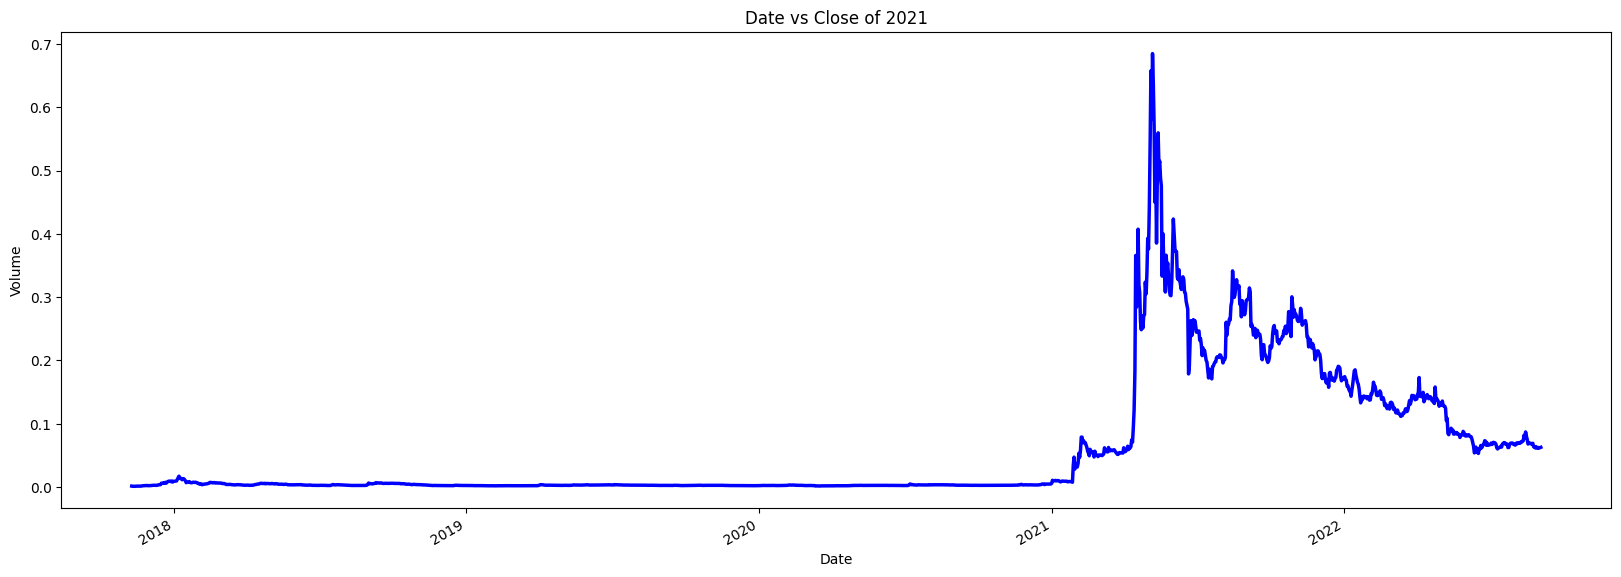

In [103]:
# Seperates the close value (because thats what we need), and we create a graph to show the data
plt.figure(figsize=(20, 7))
x = data.groupby('Date')['Close'].mean()
x.plot(linewidth=2.5, color='b')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title("Date vs Close of 2021")

In [104]:
# We are factors, some predifined and some made. These factors will help predict the price
data["gap"] = (data["High"] - data["Low"]) * data["Volume"]
data["y"] = data["High"] / data["Volume"]
data["z"] = data["Low"] / data["Volume"]
data["a"] = data["High"] / data["Low"]
data["b"] = (data["High"] / data["Low"]) * data["Volume"]

# Next, we are checking the corrolation between these factors and the close values, and sorting from highest to lowest
abs(data.corr()["Close"].sort_values(ascending=False))

Close        1.000000
Adj Close    1.000000
High         0.995104
Low          0.994575
Open         0.992514
Volume       0.588678
b            0.456479
gap          0.383333
a            0.172057
z            0.063251
y            0.063868
Name: Close, dtype: float64

In [105]:
# Create a new table with our variables and print the header
data = data[["Close", "Volume", "gap", "a", "b"]]
data.head()

,Close,Volume,gap,a,b
Date,,,,,
2017-11-09,0.001415,6259550.0,1464.73470,1.198137,7.499800e+06
2017-11-10,0.001163,4246520.0,1299.43512,1.272000,5.401573e+06
2017-11-11,0.001201,2231080.0,258.80528,1.101665,2.457903e+06
2017-11-12,0.001038,3288960.0,684.10368,1.207585,3.971698e+06
2017-11-13,0.001211,2481270.0,478.88511,1.189401,2.951226e+06


In [114]:
# Splits data into train and testing data. 
df2 = data.tail(30)
train = df2[:11]
test = df2[-19:]

# Prints the shape of the training and testing data for our information
print(train.shape, test.shape)


(11, 5) (19, 5)


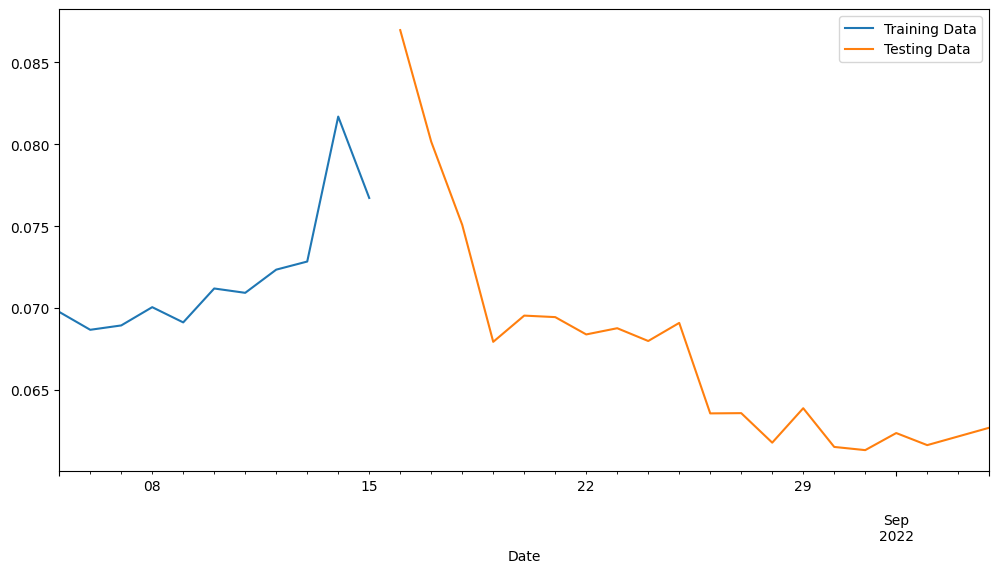

In [127]:
# Graph the training and testing data
train["Close"].plot(figsize=(12, 6))
test["Close"].plot()
plt.legend(["Training Data", "Testing Data"], loc=0)

In [112]:
# Implementing the SARIMAX model
model = SARIMAX(endog=train["Close"], exog=train.drop(
	"Close", axis=1), order=(2, 1, 1))
results = model.fit()

# Printing the results of the model
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   11
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  47.663
Date:                Tue, 26 Sep 2023   AIC                            -79.326
Time:                        22:48:09   BIC                            -76.905
Sample:                    08-05-2022   HQIC                           -81.981
                         - 08-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      7.491e-10   1.84e-10      4.077      0.000    3.89e-10    1.11e-09
gap          1.13e-08   2.45e-09      4.615      0.000     6.5e-09    1.61e-08
a             -0.0073   5.05e-15  -1.44e+12      0.0

c:\Users\nsingh\Documents\Projects\30DaysOfAI\30DaysofAIVenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nsingh\Documents\Projects\30DaysOfAI\30DaysofAIVenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\nsingh\Documents\Projects\30DaysOfAI\30DaysofAIVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nsingh\Documents\Projects\30DaysOfAI\30DaysofAIVenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

<Axes: xlabel='Date'>

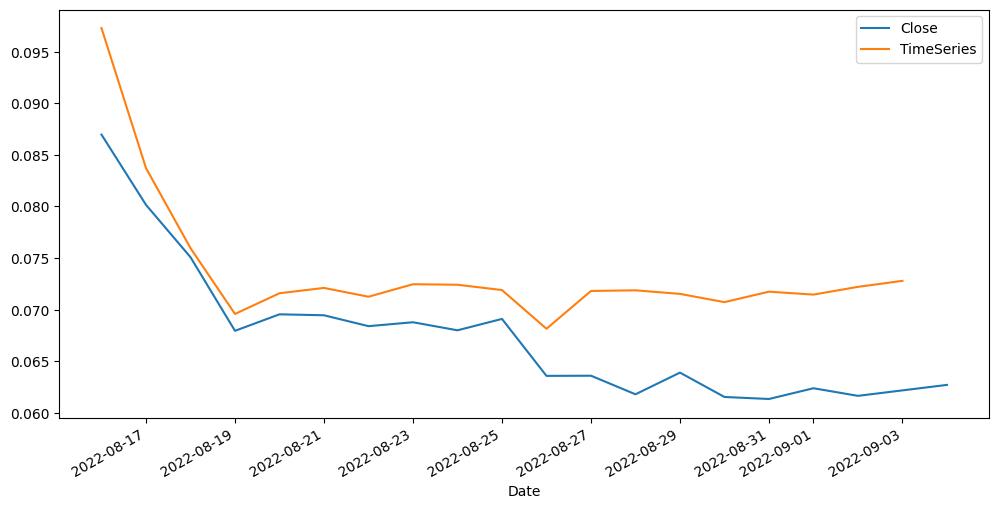

In [113]:
# Create a graph of teh prediction vs. the actual data
start = 11
end = 29
predictions = results.predict(
	start=start,
	end=end,
	exog=test.drop("Close", axis=1))
predictions

test["Close"].plot(legend=True, figsize=(12, 6))
predictions.plot(label='TimeSeries', legend=True)